In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Here write the path where you cloned the repository + ML_2019_EPFL/projects/project2/project_road_segmentation/

---



In [ ]:
%cd drive/My\ Drive/ML_2019_EPFL/projects/project2/project_road_segmentation/

/content/drive/My Drive/ML_2019_EPFL/projects/project2/project_road_segmentation


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

import os
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from tensorflow.keras.layers import GaussianNoise
from utils import *

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.regularizers import l2
from tensorflow.compat.v2.keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from tensorflow.python.client import device_lib

Using TensorFlow backend.


In [ ]:
image_dir_train = "data/training/images/"
files = os.listdir(image_dir_train)
n_train = len(files)
print(f"Loading training images, images loaded: {n_train} ")
imgs_train = np.asarray(
    [load_image(image_dir_train + files[i]) for i in range(n_train)]
)
gt_dir_train = "data/training/groundtruth/"
print(f"Loading groundtruth images, images loaded: {n_train} ")
gt_imgs_train = np.asarray(
    [load_image(gt_dir_train + files[i]) for i in range(n_train)]
)

Loading training images, images loaded: 100 
Loading groundtruth images, images loaded: 100 


In [ ]:
X_train, Y_train = imag_rotation_aug(imgs_train, gt_imgs_train)

In [ ]:
X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)

In [ ]:
print(X_train.shape)
print(Y_train.shape)
n_train = Y_train.shape[0]

(900, 456, 456, 3)
(900, 456, 456)


In [ ]:
def precision(y_true, y_pred):
    """Compute the Precision for the batch.
    Args:
        y_true (numpy.ndarray): the ground truth labels
        y_pred (numpy.ndarray): the predicted labels 
    Returns:
        Precision (numpy.float64): the Precision of the batch 
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Compute the Recall for the batch.
    Args:
        y_true (numpy.ndarray): the ground truth labels
        y_pred (numpy.ndarray): the predicted labels 
    Returns:
       Recall (numpy.float64): the Recal of the batch 
    """

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1(y_true, y_pred):
    """Compute the F-1 for the batch.
    Args:
        y_true (numpy.ndarray): the ground truth labels
        y_pred (numpy.ndarray): the predicted labels 
    Returns:
       F-1 (numpy.float64): the F-1 of the batch 
    """
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

In [ ]:
class CNN:
    def __init__(self, shape):
        self.shape = shape
        self.model = self.initialize_U_NET(shape)

    def initialize_U_NET(self, shape):
        """Create Network Architecture.
        Args:
            shape (triplet): Size of the input layer height x width x colors (64 x 64 x 3)
        Returns:
            model (Neural Network): Architecture of the model
        """
        # INPUT
        # shape     - Size of the input images
        # OUTPUT
        # model    - Compiled CNN

        # Define hyperparamters
        KERNEL3 = (3, 3)
        KERNEL5 = (5, 5)

        # Define a model
        model = Sequential()

        # Add the layers
        # Selection of the model is described in the report
        # We use padding = 'same' to avoid issues with the matrix sizes
        model.add(Conv2D(64, KERNEL5, input_shape=shape, padding="same"))
        model.add(LeakyReLU(alpha=0.1))
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Dropout(0.2))

        model.add(Conv2D(128, KERNEL3, padding="same"))
        model.add(LeakyReLU(alpha=0.1))
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Dropout(0.2))

        model.add(Conv2D(256, KERNEL3, padding="same"))
        model.add(LeakyReLU(alpha=0.1))
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Dropout(0.2))

        model.add(Conv2D(512, KERNEL3, padding="same"))
        model.add(LeakyReLU(alpha=0.1))
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Dropout(0.2))

        # Flatten it and use regularizers to avoid overfitting
        # The parameters have been chosen empirically
        model.add(Flatten())
        model.add(
            Dense(
                128, kernel_regularizer=l2(0.000001), activity_regularizer=l2(0.000001)
            )
        )
        # model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1))
        model.add(Dropout(0.5))

        # Add output layer
        model.add(
            Dense(2, kernel_regularizer=l2(0.000001), activity_regularizer=l2(0.000001))
        )
        model.add(Activation("sigmoid"))
        model.compile(
            loss="binary_crossentropy",
            optimizer=Adam(learning_rate=0.001),
            metrics=["accuracy", recall, f1],
        )

        # Print a summary of the model to see what has been generated
        model.summary()

        return model

    def train(self):
        """Train the Model.

        Returns:
            History (History_Keras): History of the training
        """
        # Early stopping callback after 10 steps
        early_stopping = EarlyStopping(
            monitor="loss", patience=10, verbose=1, restore_best_weights=True,
        )
        # Reduce learning rate on plateau after 5 steps
        lr_callback = ReduceLROnPlateau(
            monitor="loss", factor=0.8, patience=4, verbose=1, cooldown=1,
        )
        save_best = ModelCheckpoint(
            "Erick_dropout_0.2-{epoch:03d}-{f1:03f}.h5",
            save_best_only=True,
            monitor="loss",
            verbose=1,
        )
        callbacks = [lr_callback, save_best, early_stopping]

        # Train the model using the previously defined functions and callbacks
        history = self.model.fit_generator(
            create_minibatch(
                X_train, Y_train, n_train, WINDOW_SIZE, BATCH_SIZE, PATCH_SIZE, WIDTH
            ),
            steps_per_epoch=STEPS_PER_EPOCH,
            epochs=EPOCHS,
            use_multiprocessing=False,
            workers=1,
            callbacks=callbacks,
            verbose=1,
            #             validation_data=create_minibatch(
            #                 X_val, Y_val, n_val, WINDOW_SIZE, BATCH_SIZE, PATCH_SIZE, WIDTH
            #             ),
            #             validation_steps=STEPS_PER_EPOCH / 3,
        )
        return history

    def classify(self, X):
        """Classify Image as either road or not.
        Args:
            X (image): part of the image to classify
        Returns:
            Predictions : Predictions for each patch
        """
        # Subdivide the images into blocks with a stride and patch_size of 16
        img_patches = create_patches(X, 16, 16, padding=24)

        # Predict
        predictions = self.model.predict(img_patches)
        predictions = (predictions[:, 0] < predictions[:, 1]) * 1

        # Regroup patches into images
        return predictions.reshape(X.shape[0], -1)

    #         return group_patches(predictions, X.shape[0])

    def load(self, filename):
        """Loads Saved Model.
        Args:
           filename (string): name of the model
           
        """
        # Load the model (used for submission)
        dependencies = {
            "recall": recall,
            "f1": f1,
        }
        self.model = load_model(filename, custom_objects=dependencies)

    def save(self, filename):
        """Saves trained model.
        Args:
           filename (string): name of the model
           
        """
        self.model.save(filename)

In [ ]:
# We define parameters of the model
BATCH_SIZE = 1200
WINDOW_SIZE = 64
PATCH_SIZE = 16
EPOCHS = 100
STEPS_PER_EPOCH = 200
WIDTH = 448
model = CNN(shape=(WINDOW_SIZE, WINDOW_SIZE, 3))

NameError: ignored

In [ ]:
history = model.train()

Epoch 1/100
199/200 [============================>.] - ETA: 0s - loss: 0.5212 - acc: 0.7560 - recall: 0.7567 - f1: 0.7563
Epoch 00001: loss improved from inf to 0.52085, saving model to Erick_dropout_0.2-001-0.756379.h5
200/200 [==============================] - 69s 343ms/step - loss: 0.5208 - acc: 0.7560 - recall: 0.7567 - f1: 0.7564
Epoch 2/100
199/200 [============================>.] - ETA: 0s - loss: 0.4547 - acc: 0.7798 - recall: 0.7796 - f1: 0.7798
Epoch 00002: loss improved from 0.52085 to 0.45442, saving model to Erick_dropout_0.2-002-0.779993.h5
200/200 [==============================] - 62s 311ms/step - loss: 0.4544 - acc: 0.7800 - recall: 0.7798 - f1: 0.7800
Epoch 3/100
199/200 [============================>.] - ETA: 0s - loss: 0.3324 - acc: 0.8523 - recall: 0.8517 - f1: 0.8522
Epoch 00003: loss improved from 0.45442 to 0.33228, saving model to Erick_dropout_0.2-003-0.852234.h5
200/200 [==============================] - 62s 311ms/step - loss: 0.3323 - acc: 0.8523 - recall: 0

KeyError: ignored

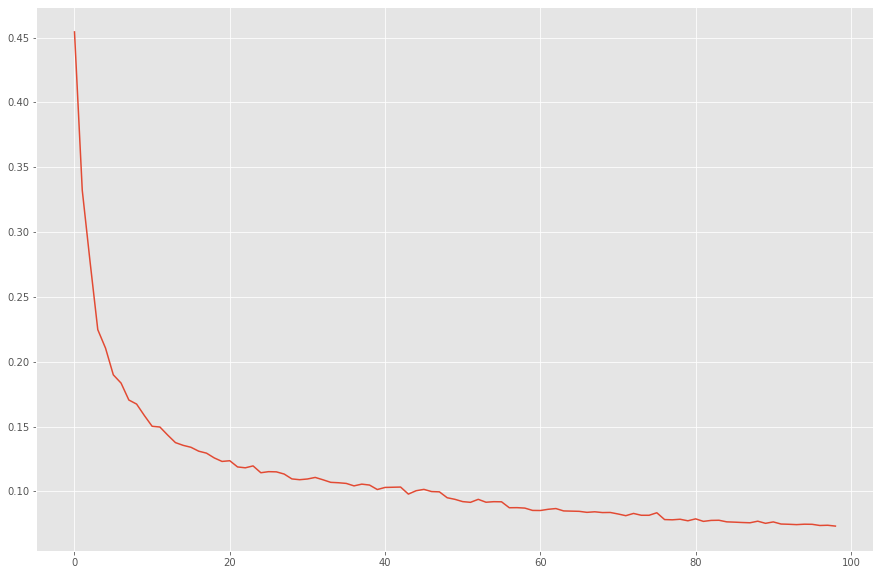

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure(figsize=(15, 10))
plt.plot(history.history["loss"][1:], label="train_loss")
# plt.plot(history.history["val_loss"][1:], label="val_loss")
plt.plot(history.history["accuracy"][1:], label="train_acc")
# plt.plot(history.history["val_accuracy"][1:], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plots/Erick_dropout_0.2.pdf")
plt.show()

In [ ]:
# Instantiate the model
model = CNN(shape=(WINDOW_SIZE, WINDOW_SIZE, 3))

# Load the model
model.load("Erick_dropout_0.2-098-0.972454.h5")

model.model.summary()

# We add all test images to an array, used later for generating a submission
image_filenames = []
for i in range(1, 51):
    image_filename = "data/test_set_images/test_" + str(i) + "/test_" + str(i) + ".png"
    image_filenames.append(image_filename)

# Set-up submission filename
submission_filename = "asdfasdf12-2.csv"

# Generates the submission
generate_submission(model, submission_filename, *image_filenames)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        4864      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
leaky_re_lu_1

OSError: ignored

In [ ]:
# Load the model
model.load("Erick_dropout_0.2-010-0.931323.h5") # cargar tu modelo con los mejores weights

# Print a summary to make sure the correct model is used
model.model.summary()

# We add all test images to an array, used later for generating a submission
image_filenames = []
for i in range(1, 51):
    image_filename = "data/test_set_images/test_" + str(i) + "/test_" + str(i) + ".png"
    image_filenames.append(image_filename)

# Set-up submission filename
submission_filename = "Erick_dropout_0.2-010-0.931323.h5.csv"

# Generates the submission
generate_submission(model, submission_filename, *image_filenames)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 64, 64, 64)        4864      
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 128)      